# Overview

# Business Case

# Data Understanding

## Limitations

# Objectives

# Data Collection and EDA

In [348]:
# Import relevant libraries
import pandas as pd
import os, shutil
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly as px
import sklearn
from sklearn.manifold import TSNE
import networkx as nx
from wordcloud import WordCloud, STOPWORDS
import random

import nltk
from nltk import bigrams, trigrams, ngrams 
from nltk.probability import FreqDist
from nltk.tokenize import regexp_tokenize, word_tokenize, RegexpTokenizer
from gensim.models import KeyedVectors
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import string
import re
import contractions
nltk.download('omw-1.4')
nltk.download('averaged_perceptron_tagger')
nltk.download('vader_lexicon')

from collections import defaultdict
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import nltk
from nltk.corpus import stopwords, wordnet
from nltk import pos_tag
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, precision_score, confusion_matrix

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, GlobalAveragePooling1D

[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/adampell/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/adampell/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/adampell/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [257]:
# Load dataset as DataFrame
# (Note: you will need a folder called "data" storing the dataset in your repo for this to work!)
df = pd.read_csv('data/train-balanced-sarcasm.csv')

In [258]:
df.head()

,label,comment,author,subreddit,score,ups,downs,date,created_utc,parent_comment
0,0,NC and NH.,Trumpbart,politics,2,-1,-1,2016-10,2016-10-16 23:55:23,"Yeah, I get that argument. At this point, I'd ..."
1,0,You do know west teams play against west teams...,Shbshb906,nba,-4,-1,-1,2016-11,2016-11-01 00:24:10,The blazers and Mavericks (The wests 5 and 6 s...
2,0,"They were underdogs earlier today, but since G...",Creepeth,nfl,3,3,0,2016-09,2016-09-22 21:45:37,They're favored to win.
3,0,"This meme isn't funny none of the ""new york ni...",icebrotha,BlackPeopleTwitter,-8,-1,-1,2016-10,2016-10-18 21:03:47,deadass don't kill my buzz
4,0,I could use one of those tools.,cush2push,MaddenUltimateTeam,6,-1,-1,2016-12,2016-12-30 17:00:13,Yep can confirm I saw the tool they use for th...


In [259]:
df = df.rename(columns={'label' : 'target'})
df.head()
df.tail()

,target,comment,author,subreddit,score,ups,downs,date,created_utc,parent_comment
1010821,1,I'm sure that Iran and N. Korea have the techn...,TwarkMain,reddit.com,2,2,0,2009-04,2009-04-25 00:47:52,"No one is calling this an engineered pathogen,..."
1010822,1,"whatever you do, don't vote green!",BCHarvey,climate,1,1,0,2009-05,2009-05-14 22:27:40,In a move typical of their recent do-nothing a...
1010823,1,Perhaps this is an atheist conspiracy to make ...,rebelcommander,atheism,1,1,0,2009-01,2009-01-11 00:22:57,Screw the Disabled--I've got to get to Church ...
1010824,1,The Slavs got their own country - it is called...,catsi,worldnews,1,1,0,2009-01,2009-01-23 21:12:49,I've always been unsettled by that. I hear a l...
1010825,1,"values, as in capitalism .. there is good mone...",frogking,politics,2,2,0,2009-01,2009-01-24 06:20:14,Why do the people who make our laws seem unabl...


In [260]:
normal_df = df[df['target'] == 0]
sarcastic_df = df[df['target'] == 1]

In [261]:
df['comment'].isna().sum()

53

In [262]:
df.dropna(subset=['comment'], inplace=True)

In [263]:
df['comment'].isna().sum()

0

In [264]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1010773 entries, 0 to 1010825
Data columns (total 10 columns):
 #   Column          Non-Null Count    Dtype 
---  ------          --------------    ----- 
 0   target          1010773 non-null  int64 
 1   comment         1010773 non-null  object
 2   author          1010773 non-null  object
 3   subreddit       1010773 non-null  object
 4   score           1010773 non-null  int64 
 5   ups             1010773 non-null  int64 
 6   downs           1010773 non-null  int64 
 7   date            1010773 non-null  object
 8   created_utc     1010773 non-null  object
 9   parent_comment  1010773 non-null  object
dtypes: int64(4), object(6)
memory usage: 84.8+ MB


In [265]:
def get_normal_comment(index):
    
    topic = normal_df.iloc[index].subreddit
    parent_comment = normal_df.iloc[index].parent_comment
    comment = normal_df.iloc[index].comment
    
    
    print(f'''Topic: {topic}\n \nParent Comment: {parent_comment}\n \nComment: {comment}''')

get_normal_comment(random.randint(0, len(normal_df)))

Topic: WTF
 
Parent Comment: They're gonna need a bigger boat.
 
Comment: They're gonna need a boat that's not made of fucking rubber!


In [266]:
def get_sarcastic_comment(index):
    
    topic = sarcastic_df.iloc[index].subreddit
    parent_comment = sarcastic_df.iloc[index].parent_comment
    comment = sarcastic_df.iloc[index].comment
    
    
    print(f'''Topic: {topic}\n \nParent Comment: {parent_comment}\n \nComment: {comment}''')

get_sarcastic_comment(random.randint(0, len(sarcastic_df)))

Topic: China
 
Parent Comment: They meant to. The police here aren't going to arrest Uygur suspects if they can kill them on the spot. Sounds harsh but that's the only explanation. Every time you hear about those raids and arrests, the police shoot first and ask questions later.
 
Comment: Well, yes, the police shoot first so they don't have to pay too much for more nut cake that they didn't want.


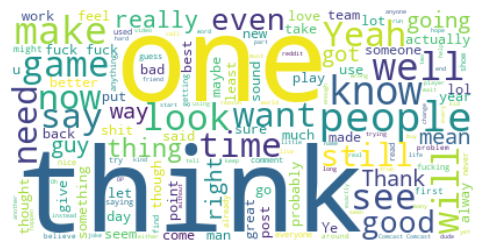

In [267]:
text_df = ' '.join([str(text) for text in normal_df['comment']])
wordcloud = WordCloud(background_color="white").generate(text_df)

# Display the generated image:
plt.figure(figsize=(6, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

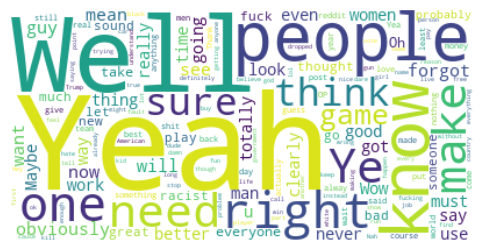

In [268]:
text_df = ' '.join([str(text) for text in sarcastic_df['comment']])
wordcloud = WordCloud(background_color="white").generate(text_df)

# Display the generated image:
plt.figure(figsize=(6, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [269]:
sampled_df = df.groupby('target').apply(lambda x: x.sample(n=20000, random_state=42)).reset_index(drop=True)

In [270]:
sampled_df['target'].value_counts()

0    20000
1    20000
Name: target, dtype: int64

In [271]:
sampled_df

,target,comment,author,subreddit,score,ups,downs,date,created_utc,parent_comment
0,0,"Joe Frazier looked up to you, Ali and you call...",SIRPORKSALOT,quotes,5,5,0,2016-06,2016-06-05 15:11:48,"""I would like to be remembered as a man who ne..."
1,0,"I hope you can make them care, care so much to...",Northern_One,photography,2,2,0,2016-06,2016-06-01 04:49:07,"Wow, it's even worse than I though. They clear..."
2,0,This forum serves a specific purpose.,nicelychill,gonewild,8,8,0,2011-07,2011-07-18 00:00:52,Why is this needed? What great crime has been ...
3,0,"Yes, I know about 1860 and outer Manchuria",barneyjosh,worldnews,1,1,0,2014-06,2014-06-09 16:19:28,You know Russia owes China a huge chunk of lan...
4,0,"But Saudi Arabia is a country where atheism, a...",xxxholicxxxx,worldnews,1,1,0,2016-07,2016-07-04 15:58:29,You mean the criminal elements of their citize...
...,...,...,...,...,...,...,...,...,...,...
39995,1,I believe it's a yippie ratdog,CP_16,Eyebleach,143,143,0,2016-05,2016-05-22 13:14:17,Anyone know what kinda dog the one in the blue...
39996,1,After watching this video I have got an urgent...,keaukraine,Android,24,24,0,2016-08,2016-08-14 08:30:13,Samsung Galaxy Note 7 Iris Scanner In Detail: ...
39997,1,Eating eathly is too expensive.,CaterpillarShrimp,food,-5,-5,0,2016-08,2016-08-19 03:55:26,Local produce all under 35$
39998,1,"Yep, men have all claim to being strong and no...",ChaosLFG,pics,3,3,0,2012-08,2012-08-27 01:58:39,She's right.


In [272]:
y = sampled_df['target']
X = sampled_df['comment']

In [273]:
X_train, X_junk, y_train, y_junk = train_test_split(X, y, test_size=0.3, shuffle=True, random_state=42)

In [274]:
X_val, X_test, y_val, y_test = train_test_split(X_junk, y_junk, test_size=0.5, shuffle=True, random_state=42)

In [275]:
X_train

38015    Because Barack Hussein Obama was our first non...
2281     Solid erg challenged fry to "Clawplawk" I believe
36629        Because knowing a racist joke = being racist.
6087                                            CRAZY TALK
11792    The issue here is that the sign says $5, and h...
                               ...                        
6265           People are raped by more than just penises.
11284                                             This lol
38158    Our eyes cant see more than 4, thats why 4K is...
860                                             ur a bogen
15795                                           Very cool.
Name: comment, Length: 28000, dtype: object

In [276]:
stopwords.words('english')[:10]

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're"]

In [277]:
sample_text = X_train.iloc[0]

stops = stopwords.words('english')
pattern = "([a-zA-Z]+(?:'[a-z]+)?|\b\d+[\w'-]*)"

tokenizer = RegexpTokenizer(pattern=pattern)
test = tokenizer.tokenize(sample_text)

new_text = [word.lower() for word in test if word.lower() not in stops]

lemmatizer = nltk.stem.WordNetLemmatizer()

final_text = [lemmatizer.lemmatize(word) for word in new_text]

print(sample_text)
final_text

Because Barack Hussein Obama was our first non-Christian president.


['barack', 'hussein', 'obama', 'first', 'non', 'christian', 'president']

In [278]:
def cleanup(comment):
    
    stops = stopwords.words('english')
    token_pattern = "([a-zA-Z]+(?:'[a-zA-Z]+)?|\b\d+[\w'-]*)"
    pattern = "([a-zA-Z]+(?:'[a-z]+)?|\b\d+[\w'-]*)"

    tokenizer = RegexpTokenizer(pattern=token_pattern)
    lemmatizer = nltk.stem.WordNetLemmatizer()
        
    tokenized_text = tokenizer.tokenize(comment)

    lowercase_text = [word.lower() for word in tokenized_text if word.lower() not in stops]
        
    lemmatized_text = [lemmatizer.lemmatize(word) for word in lowercase_text]
    
    return ' '.join(lemmatized_text)

In [279]:
cleaned_comments_train = [cleanup(comment) for comment in X_train]

cleaned_comments_val = [cleanup(comment) for comment in X_val]

cleaned_comments_test = [cleanup(comment) for comment in X_test]

In [336]:
vectorizer = TfidfVectorizer(token_pattern="([a-zA-Z]+[’']?[a-zA-Z]*|\b\d+[\w'-]*)", 
                             ngram_range=(1, 3),
                             min_df = 0.001,
                             max_df=1.0)

In [337]:
train_vecs = vectorizer.fit_transform(cleaned_comments_train)
val_vecs = vectorizer.transform(cleaned_comments_val)
test_vecs = vectorizer.transform(cleaned_comments_test)

In [338]:
dense_train_vecs = train_vecs.toarray()

df_train_vecs = pd.DataFrame(dense_train_vecs, columns=vectorizer.get_feature_names_out())

In [339]:
df_train_vecs

,able,absolutely,account,act,action,actual,actually,ad,add,added,...,yeah i'm,yeah like,yeah that's,year,year ago,year old,yep,yes,yet,yup
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27995,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
27996,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
27997,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
27998,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [340]:
# Create a DataFrame with TF-IDF scores
tfidf_sum = train_vecs.sum(axis=0)

# Calculate the average score for each n-gram.
tfidf_avg = tfidf_sum / train_vecs.shape[0]  # Divide by the number of documents

# Create a DataFrame with n-grams and their average scores.
tfidf_avg_df = pd.DataFrame(tfidf_avg.T, index=vectorizer.get_feature_names_out(), columns=['avg_score'])

# Sort the DataFrame by the average score in descending order.
tfidf_avg_df = tfidf_avg_df.sort_values(by='avg_score', ascending=False).reset_index()
tfidf_avg_df.rename(columns={'index': 'ngram'}, inplace=True)

tfidf_avg_df

,ngram,avg_score
0,like,0.018344
1,yeah,0.015171
2,get,0.013710
3,would,0.012749
4,one,0.012590
...,...,...
946,event,0.000492
947,decision,0.000490
948,cannot,0.000488
949,population,0.000486


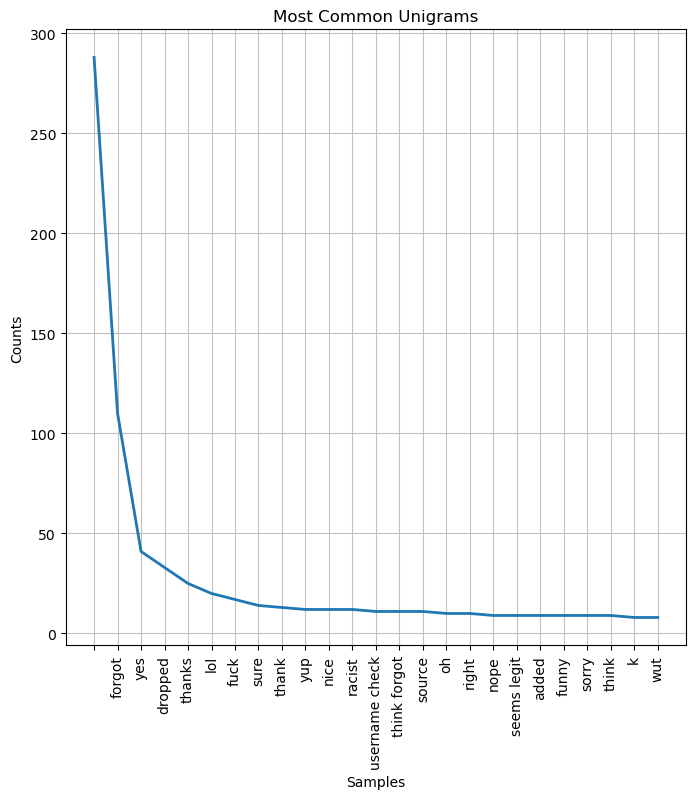

<AxesSubplot:title={'center':'Most Common Unigrams'}, xlabel='Samples', ylabel='Counts'>

In [350]:
unigrams = FreqDist(cleaned_comments_train)

plt.figure(figsize=(8, 8))
plt.title('Most Common Unigrams')
unigrams.plot(25)

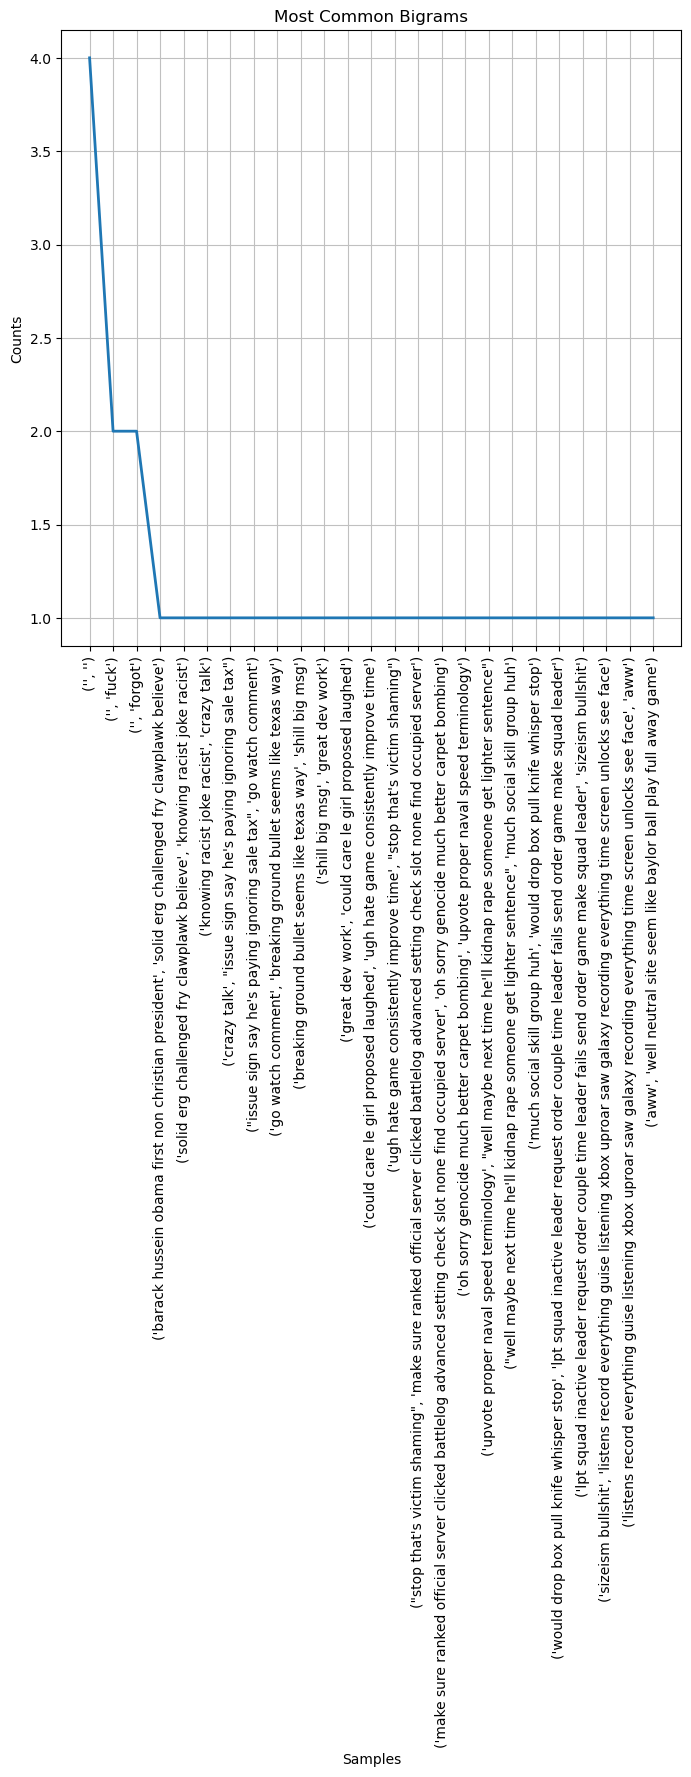

<AxesSubplot:title={'center':'Most Common Bigrams'}, xlabel='Samples', ylabel='Counts'>

In [349]:
bigrams = FreqDist(ngrams(cleaned_comments_train, 2))

plt.figure(figsize=(8, 8))
plt.title('Most Common Bigrams')
bigrams.plot(25)

In [342]:
baseline_model = MultinomialNB()

In [343]:
baseline_model.fit(train_vecs, y_train)

MultinomialNB()

In [344]:
baseline_y_hat = baseline_model.predict(val_vecs)
accuracy_score(y_val, baseline_y_hat)

0.642

In [345]:
rf_model = RandomForestClassifier()

In [346]:
rf_model.fit(train_vecs, y_train)

RandomForestClassifier()

In [347]:
rf_y_hat = rf_model.predict(val_vecs)
accuracy_score(y_val, rf_y_hat)

0.6418333333333334

,aa,ab,abandoned,ability,able,ableist,abomination,abortion,absolute,absolutely,...,zealand,zed,zelda,zero,zijn,zionist,zombie,zone,zoom,zoomed
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39995,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
39996,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
39997,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
39998,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


(         target                                            comment  \
 0             0                                         NC and NH.   
 1             0  You do know west teams play against west teams...   
 2             0  They were underdogs earlier today, but since G...   
 3             0  This meme isn't funny none of the "new york ni...   
 4             0                    I could use one of those tools.   
 ...         ...                                                ...   
 1010821       1  I'm sure that Iran and N. Korea have the techn...   
 1010822       1                 whatever you do, don't vote green!   
 1010823       1  Perhaps this is an atheist conspiracy to make ...   
 1010824       1  The Slavs got their own country - it is called...   
 1010825       1  values, as in capitalism .. there is good mone...   
 
                  author           subreddit  score  ups  downs     date  \
 0             Trumpbart            politics      2   -1     -1  2016-

NameError: name 'subreddit_counts' is not defined

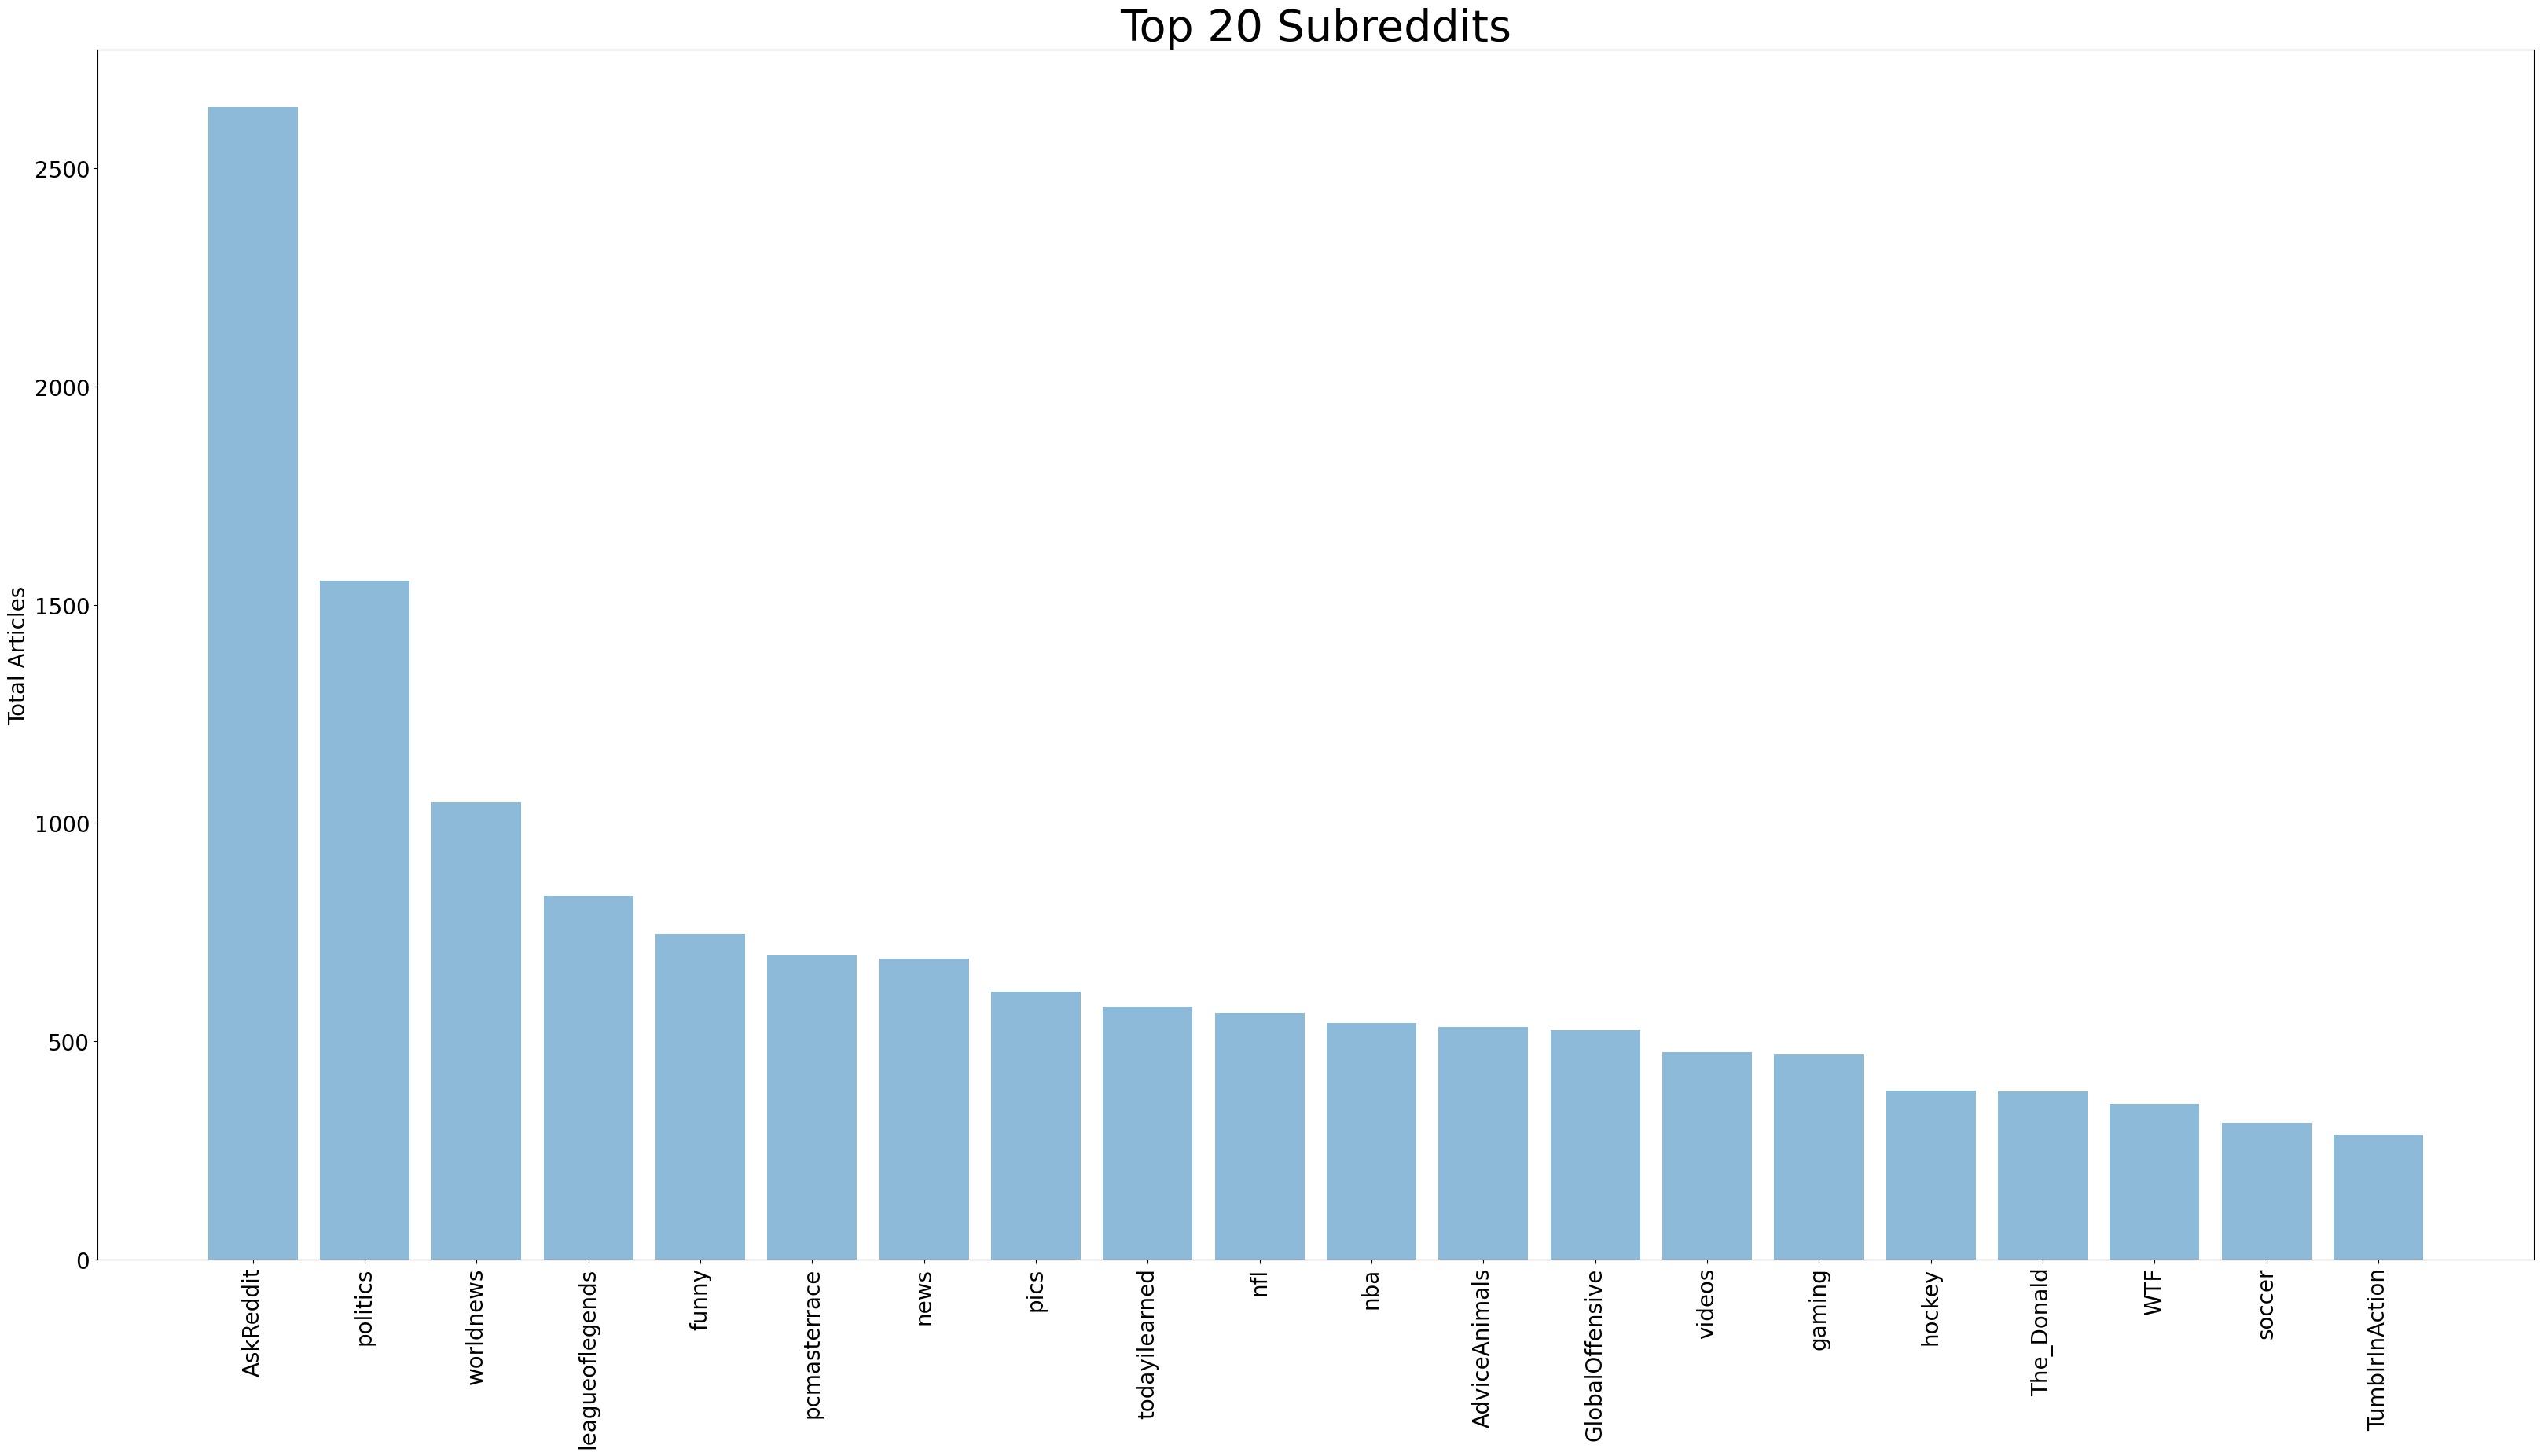

In [137]:
subreddit_counts = pd.DataFrame(sampled_df['subreddit'].value_counts()[:20])

fig, ax = plt.subplots()
fig.set_size_inches(40, 20)   
plt.xticks(fontsize=20, rotation=90)
plt.bar(list(subreddit_counts.index), list(subreddit_counts.subreddit), align='center', alpha=0.5)
plt.ylabel('Total Subteddits', fontsize=20)
plt.yticks(fontsize=20)
ax.set_title("Top 20 Subreddits", fontsize=40)
 
plt.show()

In [ ]:
# Your preprocessing remains the same
indices_to_keep_train = [idx for idx, comment in enumerate(cleaned_comments_train) if comment.strip()]
cleaned_comments_train = [cleaned_comments_train[idx] for idx in indices_to_keep_train]

indices_to_keep_val = [idx for idx, comment in enumerate(cleaned_comments_val) if comment.strip()]
cleaned_comments_val = [cleaned_comments_val[idx] for idx in indices_to_keep_val]

indices_to_keep_test = [idx for idx, comment in enumerate(cleaned_comments_test) if comment.strip()]
cleaned_comments_test = [cleaned_comments_test[idx] for idx in indices_to_keep_test]

# Now, applying Option 2 for filtering y_train, y_val, and y_test using .iloc
y_train = y_train.iloc[indices_to_keep_train]
y_val = y_val.iloc[indices_to_keep_val]
y_test = y_test.iloc[indices_to_keep_test]

In [ ]:
y_train = y_train.reset_index(drop=True)
y_val = y_val.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

# Now you can filter
y_train = [y_train[idx] for idx in indices_to_keep_train]
y_val = [y_val[idx] for idx in indices_to_keep_val]
y_test = [y_test[idx] for idx in indices_to_keep_test]

In [ ]:
cv = CountVectorizer(ngram_range=(1, 2), min_df=5, max_df=1.0)

X_t_vec = cv.fit_transform(cleaned_comments)
X_t_vec = pd.DataFrame.sparse.from_spmatrix(X_t_vec)
X_t_vec.columns = sorted(cv.vocabulary_)
X_t_vec.set_index(target.index, inplace=True)

# Hypothesis Testing?

# Conclusions

## Next Steps

## Contact Information